In [1]:
#%matplotlib widget

import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const


### This tutorial demonstrates how to create a simple tranmission spectrum for any atomic species and for a range of temperatures

This will use the same model as before, but use different cross-sections. As before, the main ingredient we need are wavelength-dependent cross-sections. These are computed from quantum mechanics calculations, and/or from lab measurements. The best cross-sections are typically computed and then refined with lab data.

A list of cross sections for atomic species is contained in the (hdf5 file) CrossSections.h5 file for a range of temperatures. *Note that this is a very large data file, you may not need all of the cross-sections!*

This can be downloaded from here:
https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/Ea9B1yv7Uz9OvRCHK0qVSQgBSIpy9bLDoSm4SDYi0f2zug?e=zavncu

You can view the contents of the file from the command line, via the h5ls command. Note that hdf5 files act like file systems.

`> h5ls CrossSections.h5`

or

`> h5ls CrossSections.h5/3000K`

The file contains cross-sections for 2000, 2500, 3000, 3500, 4000 and 4500 K, for a large range of atomic species and their singly-ionised counterparts.



<KeysViewHDF5 ['2000K', '2500K', '3000K', '3500K', '4000K', '4500K', 'w_air', 'w_vacuum']>
<KeysViewHDF5 ['spec_Ag_I', 'spec_Ag_II', 'spec_Al_I', 'spec_Al_II', 'spec_Ar_I', 'spec_Ar_II', 'spec_As_I', 'spec_B_I', 'spec_B_II', 'spec_Ba_I', 'spec_Ba_II', 'spec_Be_I', 'spec_Be_II', 'spec_C_I', 'spec_C_II', 'spec_Ca_I', 'spec_Ca_II', 'spec_Cd_I', 'spec_Cd_II', 'spec_Ce_I', 'spec_Ce_II', 'spec_Cl_I', 'spec_Cl_II', 'spec_Co_I', 'spec_Co_II', 'spec_Cr_I', 'spec_Cr_II', 'spec_Cs_I', 'spec_Dy_I', 'spec_Dy_II', 'spec_Er_I', 'spec_Er_II', 'spec_Eu_I', 'spec_Eu_II', 'spec_F_I', 'spec_F_II', 'spec_Fe_I', 'spec_Fe_II', 'spec_Ga_I', 'spec_Ga_II', 'spec_Gd_I', 'spec_Gd_II', 'spec_Ge_I', 'spec_Ge_II', 'spec_Hf_I', 'spec_Hf_II', 'spec_Ho_I', 'spec_Ho_II', 'spec_In_I', 'spec_In_II', 'spec_Ir_I', 'spec_Ir_II', 'spec_K_I', 'spec_K_II', 'spec_La_I', 'spec_La_II', 'spec_Li_I', 'spec_Li_II', 'spec_Lu_I', 'spec_Lu_II', 'spec_Mg_I', 'spec_Mg_II', 'spec_Mn_I', 'spec_Mn_II', 'spec_Mo_I', 'spec_Mo_II', 'spec_N_I', 

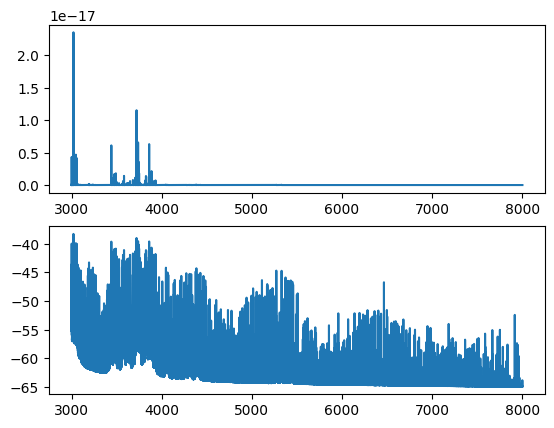

In [2]:
#get the cross-section for FeI (FeI is neutral iron, FeII is single ionised, etc...)
#note that the cross-sections also change with temperature. In general exoplanet atmospheres will have a range of temps
#but we will assume a single, isothermal atmosphere
#in addition, cross-sections change with pressure, which we will also ignore

cross_sections = '/Users/ng/MyPython/PlanetAtmos/LineLists/CrossSections.h5'
Temp = '2500K'
species = 'Fe_I'
chi_species = 1e-6 #define abundance in volume mixing ratio
Pcloud = 1e-3 #define altitude of clouds, in bar
wl_lower,wl_upper = 3000,8000 # lower,upper wavelengths in Angstrom
output_file = 'model_{}_{}'.format(Temp,species)
wl_type = 'w_vacuum' # or wl_air, ie select air or vacuum wavelengths

#note that these cross-sections are in cm^2, need to convert to m2
with h5py.File(cross_sections,'r') as F:
    print (F.keys())
    print (F['{}'.format(Temp)].keys()) #print available cross-sections
    wl = F[wl_type][:] #c
    print(wl.min(),wl.max())
    w_index = (wl>3000) * (wl<8000) #filter out unnecessary wavelengths
    wl = wl[w_index]
    sigma = F['{}/spec_{}'.format(Temp,species)][w_index]  / 1.e4 #m2

#plot the cross-section
f,a = plt.subplots(2)
a[0].plot(wl,sigma)
a[1].plot(wl,np.log(sigma))


Text(0, 0.5, 'effective planetary radius (m)')

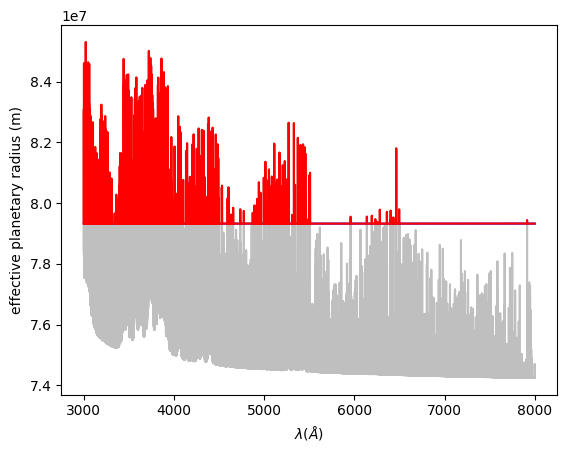

In [3]:
#Now everything proceeds as before, with new cross-sections

## Need to adjust the parameters below for other planets ##

T = 2300 #atmospheric temperature in K, this is only used to calcualte the scale height
  #ie can be adjusted separately to the opacity temperature
Rstar = 1.756*const.R_sun.value #stellar radius in m
Mpl = 0.894*const.M_jup.value #planet mass in kg
Rpl = 0.10852*const.R_sun.value #planet radius in m
mmw = 2.3 *const.m_p.value #mean molecular weight kg
gamma = 0.54

## Don't touch anything below here ##

#derive quantities
g = const.G.value * Mpl / Rpl**2 #surface gravity of planet
Hs = const.k_B.value * T / (2.3*const.m_p.value * g) #calcualte atmospheric scale height
P0 = 10. * 100000. #reference pressure, bar to Pa at R0
R0 = Rpl #reference radius

#calculate constant of model
K = R0 + Hs * (gamma + np.log(P0 / g) - np.log(mmw) + 0.5*np.log(2.*np.pi*R0/Hs) )

#calcualte the transmission spectrum
r_species = K + Hs * np.log(chi_species * sigma) #this is in units of m

#calculate radius of cloud deck, which forms the continuum
r_continuum = Hs * np.log(P0/Pcloud/100000.) + R0

#truncate the tranmission spectrum at the altitude of the cloud deck (as atmosphere is completely opaque lower down)
r = np.maximum(r_species,r_continuum)

#finally make a plot of the transmission spectrum
f,a = plt.subplots(1)
a.plot(wl,r_species,'0.5',alpha=0.5)
a.plot(wl,r_continuum * np.ones(wl.size),'b-')
a.plot(wl,r,'r-')
a.set_xlabel(r'$\lambda (\AA)$')
a.set_ylabel(r'effective planetary radius (m)')


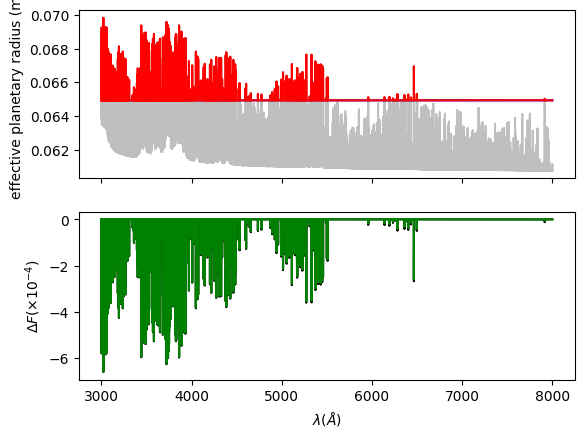

In [4]:
#often we want our tranmission spectrum in different units

#convert to units of Rp/Rs - often used for low-resolution transmission spectra
# as this is what we measure directly from transit light curves
rprs = r / Rstar
rprs_continuum = r_continuum / Rstar
rprs_species = r_species / Rstar

#for high-res, often we want units in negative delta flux
dflux = - (rprs**2 - rprs_continuum**2)

f,a = plt.subplots(2,sharex='all')
a[0].plot(wl,rprs_species,'0.5',alpha=0.5)
a[0].plot(wl,rprs_continuum * np.ones(wl.size),'b-')
a[0].plot(wl,rprs,'r-')
a[0].set_ylabel(r'effective planetary radius (m)')
a[1].plot(wl,dflux * 10000,'k-')
a[1].set_xlabel(r'$\lambda (\AA)$')
a[1].set_ylabel(r'$\Delta F (\times 10^{-4})$')

#finally, we're going to broaden the template a little by convoluting with a Gaussian kernel
#this allows us to match the template to the real data, e.g. rotation/instrumental broadening
sigma = 2 #stdev of gaussian
k = np.exp(-0.5*np.linspace(-50,50,101)**2 / sigma**2) #create the guassian function
k /= k.sum() #normalise
dflux = np.convolve(k,dflux,'same')
a[1].plot(wl,dflux * 10000,'g-')

#save the model spectrum?
np.save(output_file,np.array([wl,dflux]))
